In [3]:
%load_ext jupyter_black

In [6]:
from glob import glob
from typing import Iterable, Mapping
import xarray as xr
import pandas as pd
import re
from wxlab import scrape

scrape.galwem().download(_slice=slice(0,4))

In [74]:
def vars_with_dims(ds: xr.Dataset, *dims: str) -> xr.Dataset:
    required_dims = tuple(sorted(dims))
    return ds[[k for k, v in ds.data_vars.items() if tuple(sorted(v.dims)) == required_dims]]


def pythonic_longname(ds: xr.Dataset) -> xr.Dataset:
    def pythonic(mapping: Mapping[str, any]):
        return {k: re.sub(r"\(|\)", "", v.long_name).replace(" ", "_").lower() for k, v in mapping.items()}

    variables = pythonic(ds.data_vars)
    coordsinates = pythonic(ds.coords)
    return ds.rename(variables | coordsinates)


def generate():
    s = pd.Series(glob("/media/external/data/*"))

    def f(df: pd.DataFrame):
        df["forecast_hour"] = df["forecast_hour"].astype("timedelta64[h]")

        galwem_condition = df.model == "GLOBAL"

        df.loc[galwem_condition, "model"] = "GALWEM"

        df.loc[galwem_condition, "model_run"] = pd.to_datetime(
            df.loc[galwem_condition, "model_run"], format="%Y%m%d%H"
        )
        return df

    def f2(df: pd.DataFrame):
        
        s.index = df["model_run"] + df["forecast_hour"]
        return s 

    return (
        s.str.extract(
            r"(?P<model>hrrr|GLOBAL)(?:\.t|\.grib2\.)(?P<model_run>\d*).*(?P<forecast_hour>\d{2,4})(?:\.grib2)?$"
        )
        .pipe(f)
        .pipe(f2)
    )


generate(), glob("/media/external/data/*")
# file = glob("/media/external/data/hrr*")[0]
# ds: xr.Dataset = xr.open_dataset(file, engine="pynio")
# ds = ds.pipe(vars_with_dims, "lv_HYBL0", "ygrid_0", "xgrid_0").pipe(pythonic_longname)
# ds

/home/leaver2000/miniconda3/envs/wxlab/lib/python3.10/site-packages/pandas/core/arrays/datetimelike.py:1189: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  warnings.warn(


(2022-06-04 06:00:00    /media/external/data/GLOBAL.grib2.2022060400.0006
 2022-06-04 12:00:00    /media/external/data/GLOBAL.grib2.2022060400.0012
 0 days 01:00:00           /media/external/data/hrrr.t00z.wrfnatf01.grib2
 0 days 00:00:00           /media/external/data/hrrr.t00z.wrfnatf00.grib2
 2022-06-04 00:00:00    /media/external/data/GLOBAL.grib2.2022060400.0000
 2022-06-04 18:00:00    /media/external/data/GLOBAL.grib2.2022060400.0018
 dtype: object,
 ['/media/external/data/GLOBAL.grib2.2022060400.0006',
  '/media/external/data/GLOBAL.grib2.2022060400.0012',
  '/media/external/data/hrrr.t00z.wrfnatf01.grib2',
  '/media/external/data/hrrr.t00z.wrfnatf00.grib2',
  '/media/external/data/GLOBAL.grib2.2022060400.0000',
  '/media/external/data/GLOBAL.grib2.2022060400.0018'])

In [5]:
df = ds[["temperature"]].to_dataframe()
df

temperature   latitude   longitude
hybrid_level ygrid_0 xgrid_0                                    
1.0          0       0         292.940491  21.138123 -122.719528
                     1         292.940491  21.145109 -122.692863
                     2         292.940491  21.152090 -122.666191
                     3         292.940491  21.159063 -122.639519
                     4         292.940491  21.166029 -122.612839
...                                   ...        ...         ...
50.0         1058    1794      228.605545  47.883305  -61.063480
                     1795      228.605545  47.873043  -61.026890
                     1796      228.668045  47.862770  -60.990314
                     1797      228.668045  47.852489  -60.953747
                     1798      228.668045  47.842194  -60.917194

[95257050 rows x 3 columns]

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

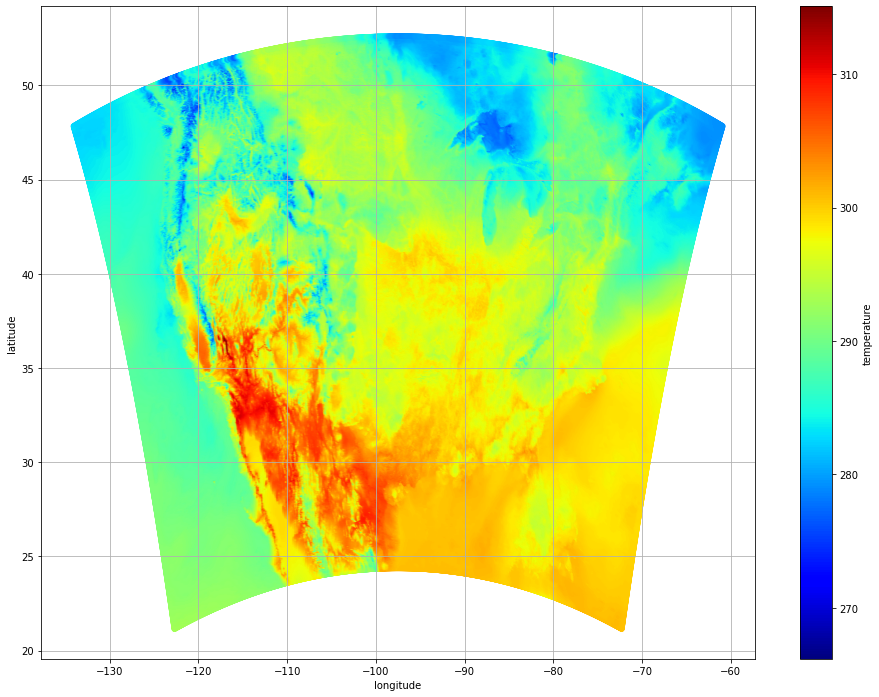

In [15]:
import matplotlib.pyplot as plt

plt.rcParams["axes.grid"] = True
hybrid_level = 1
df.loc[[hybrid_level]].plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    ax=plt.axes(),
    c="temperature",
    cmap=plt.get_cmap("jet"),
    figsize=(16, 12),
)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

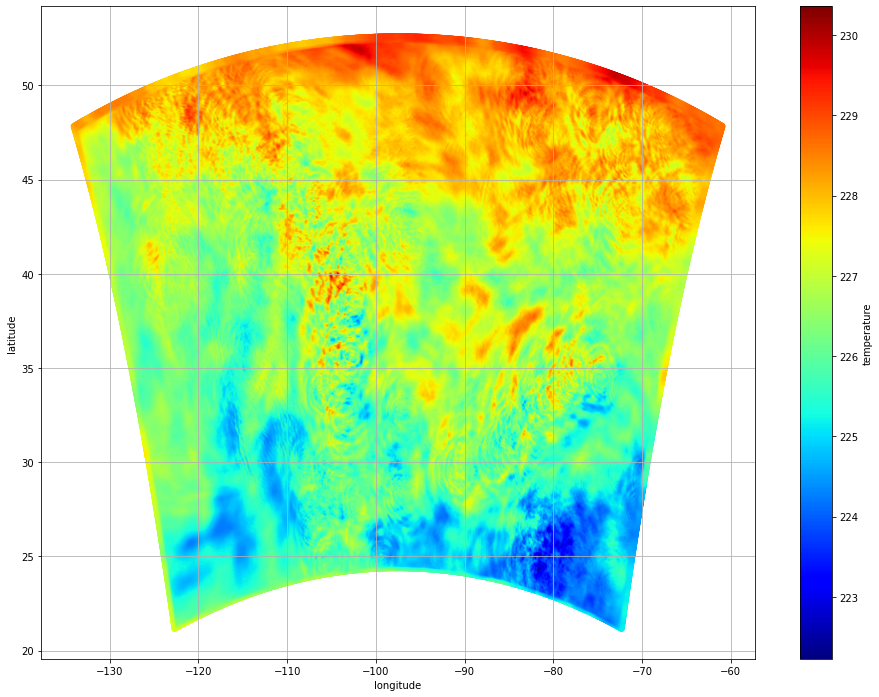

In [16]:
hybrid_level = 50
df.loc[[hybrid_level]].plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    ax=plt.axes(),
    c="temperature",
    cmap=plt.get_cmap("jet"),
    figsize=(16, 12),
)